# Anomaly detection

This notebook focuses on detection of bearing failure from [a dataset of measures made publicly available by the NASA](http://data-acoustics.com/measurements/bearing-faults/bearing-4/). The dataset was used in [a blog post by Vegard Flovik](https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7). In this notebook I will try to reproduce, explain and extend his methodology.

Data consists of individual files that are 1-second vibration signal snapshots recorded at specific intervals. Each file consists of 20,480 points with the sampling rate set at 20 kHz. The file name indicates when the data was collected. Each record (row) in the data file is a data point. The used data set (on 3 available) contains 984 files.

Three appraoches will be developped for failure detection :
 - First I'll try PCA and Mahalanobis distance
 - Secondly I'll try using an autoencoder Mean Squared Error
 - Finally I'll try a single class SVM
 
All these approaches try to learn the shape of normal data and when applied to data near failure they will find the deviation from normal data.

## Get Data

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from os import listdir, getcwd
from os.path import join

In [2]:
# Get second dataset
files = listdir(join(getcwd(), '2nd_test', '2nd_test'))
files.sort()

In [3]:
# Loading for Flovik's method
merged_data = pd.DataFrame()
for filename in files:
    dataset=pd.read_csv(join(getcwd(), '2nd_test', '2nd_test',
                             filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')

merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')

Flovik turns data into their mean absolute value, leading to a
first compression step. This steps can be considered from a signal processing view : by computing the mean absolute acceleration of each bearing at each measure point we compute the mean of signal over a window of 1 seconde. Thus we remove noise from the data.

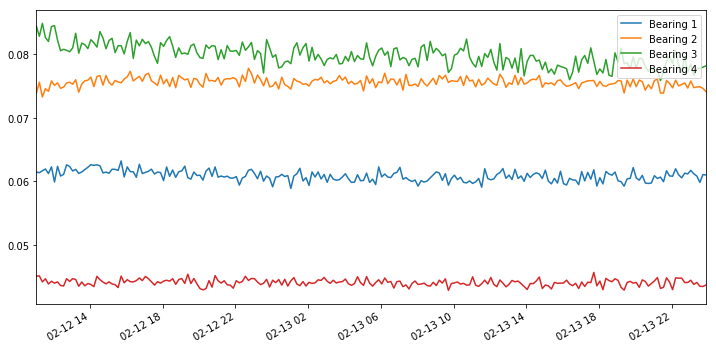

In [4]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]

dataset_train.plot(figsize = (12,6))

## Preparing dataset

In [5]:
import re

pattern_1 = "2004.02.12.*"
pattern_2 = "2004.02.13.*"
day_one = []
day_two = []
training_set = []
for f in files :
    d1 = re.findall(pattern_1, f) 
    d2 = re.findall(pattern_2, f) 
    if(len(d1) > 0) :
        day_one.append(d1[0])
        training_set.append(d1[0])
    if(len(d2) > 0) :
        day_two.append(d2[0])
        training_set.append(d2[0])
test_set = files[len(training_set):]

#### Scaling for Flovik approach

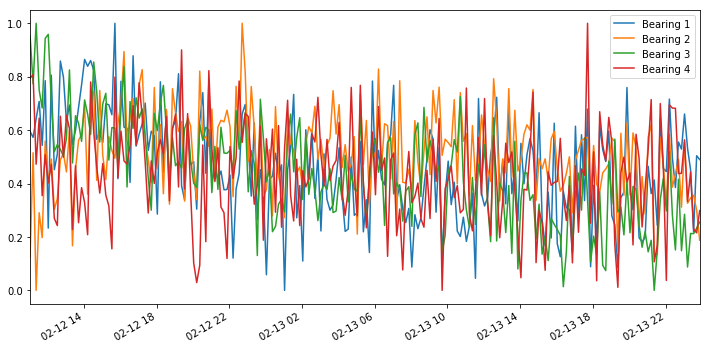

In [6]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
X_train.plot(figsize = (12,6))
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

Using the scaler allows to make the signal from the 4 bearings comparable. They all lie between 0 and 1. Thus when running PCA no bearing triggers stronger value than others.

## PCA + Mahalanobis

### My own method

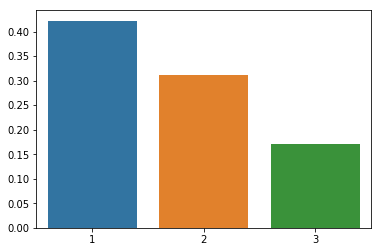

In [7]:
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from numpy import cov, array, append, ndarray, apply_along_axis, mean
from scipy.linalg import inv


# Compute PCs coordinate for initial values
pca = PCA(n_components = 3, random_state = 42, 
            svd_solver = 'arpack')
ref_pca = pca.fit_transform(pd.read_csv(join(getcwd(), '2nd_test', '2nd_test', training_set[0]), sep = "\t",
                         names = ['Bearing1', "Bearing2", "Bearing3", "Bearing4"]))

# plot explained variance 
sns.barplot(y = pca.explained_variance_ratio_, x = [1,2,3])
plt.savefig("PCA_explained_variance.png")

In [8]:
# Get parameters of reference data
def get_param(pca) :
    """
    This function computes columns means and covariance matrix of a table.
    Parameters :
    -  pca : a table, meant to result from scikitlearn PCA function
    Return :
    A dictionnary with means in "means", and inverse covariance in "inverse_covariance"
    """
    means =apply_along_axis(mean, axis = 0, arr = pca)
    inv_cov = inv(cov(pca.transpose()))
    return({"means" : means, "inverse_covariance" : inv_cov})
  
    
ref_param = get_param(ref_pca)

In [9]:
def write_reference(ref, name = "reference") :
    """
    This function write reference paramaters into separate files : one for means,
    one for inverse covariance.
    Parameters :
     - ref : a dictionnary with means in "means", and inverse covariance matrix
     in "inverse_covariance"
    """
    ref["means"].tofile(name + "_means.csv", sep = ",")
    ref["inverse_covariance"].tofile(name + "_cov.csv", sep = ",")

def read_reference(means_file, inverse_cov_file) :
    """
    Read means and inverse covariance matrix from files.
    Parameters :
     - means_file : file with the array of means
     - inverse_cov_file : file containing the array of the covariance matrix
    Return :
    A dictionnary with means in "means", and inverse covariance in "inverse_covariance" 
    """
    means = np.fromfile(means_file, sep=",")
    inv_cov = np.fromfile(inverse_cov_file, sep=",")
    invcov = np.reshape(inv_cov, (len(means), len(means)))
    ref = {"means" : means,
          "inverse_covariance": inv_cov}
    return(ref)  

write_reference(ref_param)

In [10]:
def PCA_Mahalanobis(data, n_components, ref) :
    """
    Computes the mahalanobis distance of data points from a reference after dimensionality
    reduction by PCA
    Parameters :
     - data : the data with dimensions in columns
     - n_components : number of component to keep
     - ref : a dictionnary with means in "means", and inverse covariance in "inverse_covariance" 
    Returns :
     An array with the mean mahalanobis distance for the data. 
    """
    
    # define maximum number of PCs
    if n_components >= data.shape[1] :
         n_components = data.shape[1] - 1
            
    pca = PCA(n_components = n_components, random_state = 42, 
              svd_solver = 'arpack')
    new_coord = pca.fit_transform(data)
    dist_list = []
    for row in range(data.shape[1] + 1) :
        dist = mahalanobis(ref["means"], 
                           new_coord[row],
                           ref["inverse_covariance"])
        dist_list.append(dist)
    return(mean(dist_list))

mahal_dist = []
for f in training_set[1:] :
    table = pd.read_csv(join(getcwd(), '2nd_test', '2nd_test', f), sep = "\t",
                         names = ['Bearing1', "Bearing2", "Bearing3", "Bearing4"])
    m_dist = PCA_Mahalanobis(table, 3, ref_param)
    mahal_dist.append(m_dist)
mahal_dist = array(mahal_dist)

C:\Users\NOTEBOOK\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


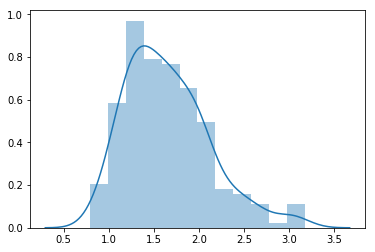

In [11]:
# Plot reference Mahalanobis distances distribution
sns.distplot(mahal_dist)
plt.savefig("Mahalanobis_distribution.png")

In [12]:
# Compute distances on test set
distances = []
for f in test_set :
    table = pd.read_csv(join(getcwd(), '2nd_test', '2nd_test', f), sep = "\t",
                         names = ['Bearing1', "Bearing2", "Bearing3", "Bearing4"])
    m_dist = PCA_Mahalanobis(table, 3, ref_param)
    distances.append(m_dist)

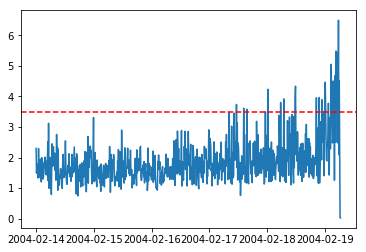

In [13]:
# Plot distances over time
dates = [file_name.replace(".", "/", 2) for file_name in test_set]
dates = [file_name.replace(".", " ", 1) for file_name in dates]
dates = [file_name.replace(".", ":") for file_name in dates]

sns.lineplot(y = distances, x =  pd.to_datetime(pd.Series(dates), yearfirst = True))
plt.axhline(y = 3.5, color='r', linestyle='--')
plt.savefig("Mahalanobis_threshold.png")

In [14]:
# Save results
res = pd.DataFrame({
    "Date": dates,
    "Mean_Mahalanobis": distances,
    "Failure": [distance > 3.5 for distance in distances]
})
res.to_csv('Mahalanobis_distance.csv')
res[495:505]

,Date,Mean_Mahalanobis,Failure
495,2004/02/17 10:32:39,1.908871,False
496,2004/02/17 10:42:39,2.010467,False
497,2004/02/17 10:52:39,2.503905,False
498,2004/02/17 11:02:39,2.212107,False
499,2004/02/17 11:12:39,3.739426,True
500,2004/02/17 11:22:39,1.674481,False
501,2004/02/17 11:32:39,3.137308,False
502,2004/02/17 11:42:39,1.263233,False
503,2004/02/17 11:52:39,2.470626,False
504,2004/02/17 12:02:39,2.333666,False


### Vegard Flovik's Method

In [15]:
# compute PCA
pca = PCA(n_components=2, svd_solver= 'full')

X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [16]:
# Get parameters
params = get_param(data_train)

write_reference(params, name = "Flovik")

In [17]:
def Mahalanobis_distance(data, ref) :
    """
    Computes the mahalanobis distance of data points with dimensionality reduced by PCA
    from a reference
    Parameters :
     - data : the data with dimensions in columns
     - ref : a dictionnary with means in "means", and inverse covariance in "inverse_covariance" 
    Returns :
     An array with the mean mahalanobis distance for the data. 
    """
    dist_list = []
    for row in range(data.shape[0]) :
        dist = mahalanobis(ref["means"], 
                           data[row],
                           ref["inverse_covariance"])
        dist_list.append(dist)
    return(dist_list)

distances = Mahalanobis_distance(data_train, params)

C:\Users\NOTEBOOK\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


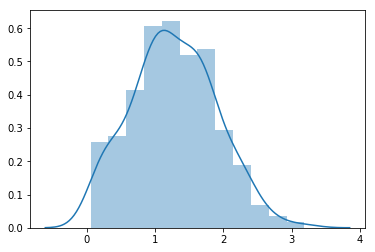

In [18]:
# Plot reference Mahalanobis distances distribution
sns.distplot(distances)
plt.savefig("Flovik_Mahalanobis_distribution.png")

In [19]:
def get_threshold(distances, n_sd = 3) :
    """
    Computes trheshold value using mean value + a given number of standard deviations
    Parameters :
     - distances : array of float
     - n_sd : number of standard deviations
    """
    threshold = np.mean(distances) + n_sd * np.std(distances)
    return(threshold)

limit_value = get_threshold(distances, 4)

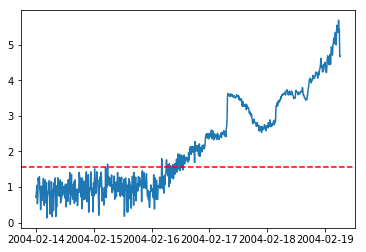

In [20]:
distances = Mahalanobis_distance(data_test, params)

sns.lineplot(y = np.log(np.array(distances) + 1), x =  X_test.index)
plt.axhline(y = np.log(limit_value + 1), color='r', linestyle='--')
plt.savefig("Flovik_Mahalanobis_threshold.png")

In [21]:
res = pd.DataFrame({
    "Date": X_test.index,
    "Mean_Mahalanobis": distances,
    "Failure": [distance > limit_value for distance in distances]
})
res.to_csv('Flovik_Mahalanobis_distance.csv')
res[310:320]

,Date,Mean_Mahalanobis,Failure
310,2004-02-16 03:32:39,1.617560,False
311,2004-02-16 03:42:39,1.794457,False
312,2004-02-16 03:52:39,1.812086,False
313,2004-02-16 04:02:39,1.712335,False
314,2004-02-16 04:12:39,5.031201,True
315,2004-02-16 04:22:39,3.681988,False
316,2004-02-16 04:32:39,1.598158,False
317,2004-02-16 04:42:39,1.729748,False
318,2004-02-16 04:52:39,1.998568,False
319,2004-02-16 05:02:39,2.614594,False


Flovik's method allow for earlier detection and cleaner results. This is due to :
 - 1 : Considering only acceleration value independant of the direction
 - 2 : Considering mean value for each time-point thus leading to cleaner signal
 - 3 : Computation of reference over the whole training set

## Autoencoder

In [22]:
from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model

Using TensorFlow backend.


This time we have no choice but to use the full dataset for training. Compaction with sliding mean is essential to allow computation.

### My own model

In [23]:
seed(10)
set_random_seed(10)

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100 # number of iteration over dataset
BATCH_SIZE=10 # subset of data set to use to update model, 
#               all btches are considered during each epoch

# Build model
model = Sequential()

# Model is 4 -> 3 -> 2 -> 3 -> 4
model.add(Dense(3, input_dim=4, activation = 'relu', kernel_initializer='glorot_uniform'))
model.add(Dense(2, activation = 'elu', kernel_initializer='glorot_uniform'))
model.add(Dense(3, activation = 'elu', kernel_initializer='glorot_uniform'))
model.add(Dense(4, activation = 'elu', kernel_initializer='glorot_uniform'))

model.compile(optimizer='adam',
              loss='mean_squared_error')

We use the elu (Exponential linear unit) activation function, which returns x if x > 0 and
exp((x)-1) if x < 0). Here all values are positives so the activation functions is set to return x. No difference was observed based on variation of the initialization of weights. This may mean that model training is complete after 100 iterations, and thus results are stable.

In [24]:
# Fit model
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1) # verbose is set to True in order to get history of loss function

Train on 210 samples, validate on 12 samples
Epoch 1/100
210/210 [==============================] - 0s 2ms/step - loss: 0.2721 - val_loss: 0.2192
Epoch 2/100
210/210 [==============================] - 0s 190us/step - loss: 0.2200 - val_loss: 0.1832
Epoch 3/100
210/210 [==============================] - 0s 143us/step - loss: 0.1842 - val_loss: 0.1551
Epoch 4/100
210/210 [==============================] - 0s 237us/step - loss: 0.1554 - val_loss: 0.1301
Epoch 5/100
210/210 [==============================] - 0s 238us/step - loss: 0.1297 - val_loss: 0.1064
Epoch 6/100
210/210 [==============================] - 0s 238us/step - loss: 0.1071 - val_loss: 0.0855
Epoch 7/100
210/210 [==============================] - 0s 306us/step - loss: 0.0874 - val_loss: 0.0683
Epoch 8/100
210/210 [==============================] - 0s 218us/step - loss: 0.0716 - val_loss: 0.0550
Epoch 9/100
210/210 [==============================] - 0s 191us/step - loss: 0.0593 - val_loss: 0.0457
Epoch 10/100
210/210 [========

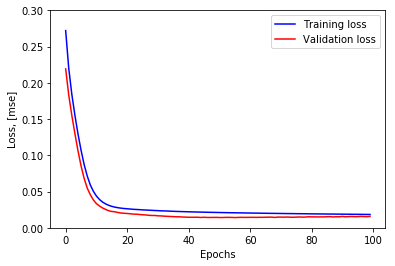

In [25]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.3])
plt.show()

In [26]:
# Use model and compute mean absolute error
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

C:\Users\NOTEBOOK\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


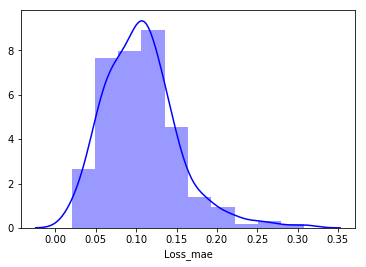

In [27]:
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue')

mae = scored['Loss_mae']

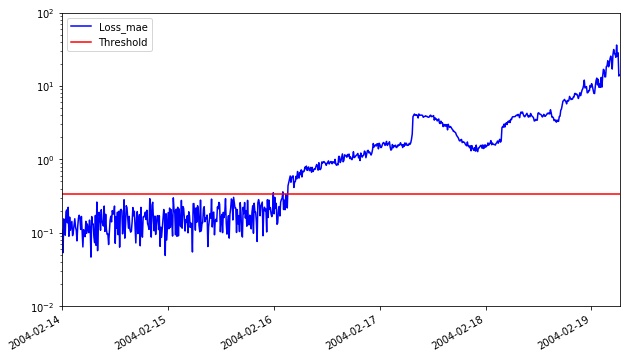

In [28]:
# Compute prediction on test set
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = get_threshold(mae, 5)
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

In [29]:
scored.to_csv('Autoencoder_mae.csv')
scored[300:310]

,Loss_mae,Threshold,Anomaly
2004-02-16 01:52:39,0.297142,0.336716,False
2004-02-16 02:02:39,0.361480,0.336716,True
2004-02-16 02:12:39,0.207377,0.336716,False
2004-02-16 02:22:39,0.278871,0.336716,False
2004-02-16 02:32:39,0.206351,0.336716,False
2004-02-16 02:42:39,0.332187,0.336716,False
2004-02-16 02:52:39,0.295329,0.336716,False
2004-02-16 03:02:39,0.217963,0.336716,False
2004-02-16 03:12:39,0.435979,0.336716,True
2004-02-16 03:22:39,0.484838,0.336716,True


### Flovik's model

In [30]:
# Build Flovik's model
model = Sequential()

# Model is 4 -> 10 -> 2 -> 10 -> 4
model.add(Dense(10, input_dim=4, activation = 'elu', kernel_initializer='glorot_uniform'))
model.add(Dense(2, activation = 'elu', kernel_initializer='glorot_uniform'))
model.add(Dense(10, activation = 'elu', kernel_initializer='glorot_uniform'))
model.add(Dense(4, activation = 'elu', kernel_initializer='glorot_uniform'))

model.compile(optimizer='adam',
              loss='mean_squared_error')

In [31]:
# Fit model
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)

Train on 210 samples, validate on 12 samples
Epoch 1/100
210/210 [==============================] - 0s 2ms/step - loss: 0.1001 - val_loss: 0.0353
Epoch 2/100
210/210 [==============================] - 0s 224us/step - loss: 0.0421 - val_loss: 0.0202
Epoch 3/100
210/210 [==============================] - 0s 182us/step - loss: 0.0241 - val_loss: 0.0255
Epoch 4/100
210/210 [==============================] - 0s 198us/step - loss: 0.0219 - val_loss: 0.0264
Epoch 5/100
210/210 [==============================] - 0s 143us/step - loss: 0.0212 - val_loss: 0.0247
Epoch 6/100
210/210 [==============================] - 0s 190us/step - loss: 0.0205 - val_loss: 0.0247
Epoch 7/100
210/210 [==============================] - 0s 239us/step - loss: 0.0199 - val_loss: 0.0239
Epoch 8/100
210/210 [==============================] - 0s 191us/step - loss: 0.0192 - val_loss: 0.0239
Epoch 9/100
210/210 [==============================] - 0s 188us/step - loss: 0.0187 - val_loss: 0.0230
Epoch 10/100
210/210 [========

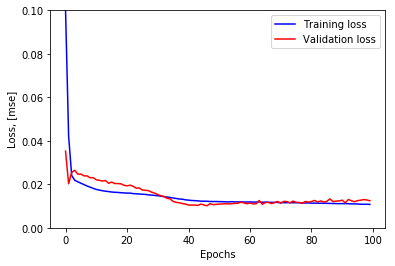

In [32]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

In [33]:
# Use model and compute mean absolute error
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)

C:\Users\NOTEBOOK\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


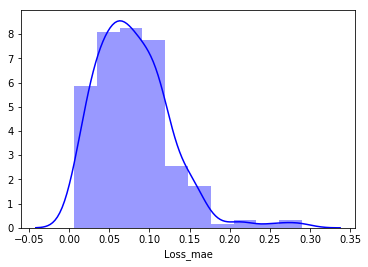

In [34]:
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue')

mae = scored['Loss_mae']

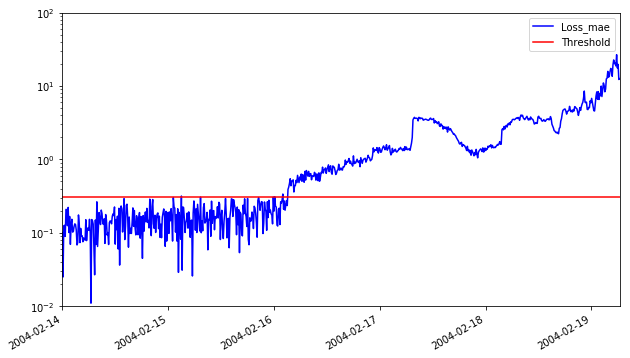

In [35]:
# Compute prediction on test set
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = get_threshold(mae, 5)
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

In [36]:
scored.to_csv('Flovik_Autoencoder_mae.csv')
scored[300:310]

,Loss_mae,Threshold,Anomaly
2004-02-16 01:52:39,0.282433,0.31107,False
2004-02-16 02:02:39,0.337438,0.31107,True
2004-02-16 02:12:39,0.209569,0.31107,False
2004-02-16 02:22:39,0.271575,0.31107,False
2004-02-16 02:32:39,0.203127,0.31107,False
2004-02-16 02:42:39,0.238310,0.31107,False
2004-02-16 02:52:39,0.274928,0.31107,False
2004-02-16 03:02:39,0.235273,0.31107,False
2004-02-16 03:12:39,0.389154,0.31107,True
2004-02-16 03:22:39,0.420112,0.31107,True


Both models gives equivalent results. However loss function of the 10 neurons model is closer to zero has would be expected from a more complex model.

## Single Class SVM

In [37]:
#Ongoing

## Wavelets trial

In [38]:
import pywt

# discrete wavelet transform
data = pd.read_csv(join(getcwd(), '2nd_test', '2nd_test', files[0]), sep = "\t",
                         names = ['Bearing1', "Bearing2", "Bearing3", "Bearing4"])
cA, cD = pywt.dwt(data["Bearing1"], 'sym6')

C:\Users\NOTEBOOK\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


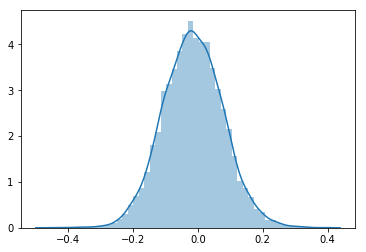

In [39]:
sns.distplot(cA)

C:\Users\NOTEBOOK\Miniconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


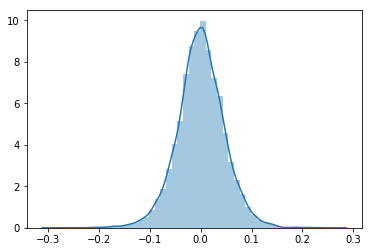

In [40]:
sns.distplot(cD)